Lucas Henneçon

In [ ]:
%%capture
!pip install transformers datasets tabulate

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import math
from torch.utils.data import DataLoader
from datasets import load_dataset
from tabulate import tabulate

from tqdm.notebook import tqdm
from transformers import BertTokenizer

In [ ]:
class Conv1dClassifier(nn.Module):
    """A text classifier:
    - input = minibatch
    - output = probability associated to a binary classification task
    - vocab_size: the number of words in the vocabulary we want to embed
    - embedding_dim: size of the word vectors
    """

    def __init__(self, vocab_size, embedding_dim, feature_size=100, kernel_size=3):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.feature_size = feature_size
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        # The number of padding symbols depends on the kernel size.
        # It is important to ensure that we have always a sequence
        # as long as the kernel size.
        # ex: if ks=3, we add 1 padding before and one after.
        # The sentence "Great" becomes "<pad> Great <pad>"
        self.conv = nn.Conv1d(
            embedding_dim,
            feature_size,
            kernel_size,
            padding=math.floor(kernel_size / 2),
        )
        # The parameter for AdaptiveMaxPool1d is the "output size"
        # or the number of output values for a dimension.
        # Here it is one: we want to get the max for every components.
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.dropout = nn.Dropout(0.3)
        self.linear = nn.Linear(feature_size, 1)
        self.out_activation = nn.Sigmoid()

    def forward(self, input_ids):
        # In pytorch, convolution expects (B,d,L)
        # B: the batch dimension
        # d: the embedding dimension
        # L: the length of the sequence
        hidden_states = self.embeddings(input_ids).permute(0, 2, 1)
        hidden_states = F.relu(self.conv(hidden_states))
        hidden_states = self.pool(hidden_states)  # --> (B,d,1)
        # Before the linear, do something with dims the dimension
        # Because Linear works on the final dim
        # (B,d,1) -> (B,d)
        hidden_states = hidden_states.squeeze(dim=2)
        hidden_states = self.dropout(hidden_states)
        logits = self.linear(hidden_states)
        return self.out_activation(logits)

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
def load_model(path, vocab_size, embedding_dim, feature_size=100, kernel_size=3):
    model = Conv1dClassifier(vocab_size, embedding_dim, feature_size, kernel_size)
    checkpoint = torch.load(path)
    model.embeddings.weight.data.copy_(checkpoint["Ew"])
    print(f"Pre-trained embeddings loaded from {path} into Conv1dClassifier.")

    return model

In [ ]:
dataset = load_dataset("scikit-learn/imdb", split="train")
print(dataset)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.22k [00:00<?, ?B/s]

IMDB Dataset.csv:   0%|          | 0.00/66.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset({
    features: ['review', 'sentiment'],
    num_rows: 50000
})


In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", do_lower_case=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
print("Type of the tokenizer:", type(tokenizer.vocab))
VOCSIZE = len(tokenizer.vocab)
print("Length of the vocabulary:", VOCSIZE)

# Print some keys from the vocabulary
print("Some keys from the vocabulary:", list(tokenizer.vocab.keys())[9000:9010])

Type of the tokenizer: <class 'collections.OrderedDict'>
Length of the vocabulary: 30522
Some keys from the vocabulary: ['screenplay', '##bird', 'contribute', 'indonesian', 'pet', 'creates', '##com', 'enzyme', 'kylie', 'discipline']


In [ ]:
def preprocessing_fn(x, tokenizer):
    x["review_ids"] = tokenizer(
        x["review"],
        add_special_tokens=False,
        truncation=True,
        max_length=256,
        padding=False,
        return_attention_mask=False,
    )["input_ids"]
    x["label"] = 0 if x["sentiment"] == "negative" else 1
    return x

In [ ]:
n_samples = 5000  # the number of training example

# We first shuffle the data !
dataset = dataset.shuffle()

# Select 5000 samples
splitted_dataset = dataset.select(range(n_samples))

# Tokenize the dataset
splitted_dataset = splitted_dataset.map(
    preprocessing_fn, fn_kwargs={"tokenizer": tokenizer}
)


# Remove useless columns
splitted_dataset = splitted_dataset.select_columns(["review_ids", "label"])

# Split the train and validation
splitted_dataset = splitted_dataset.train_test_split(test_size=0.2)

train_set = splitted_dataset["train"]
valid_set = splitted_dataset["test"]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

In [ ]:
class DataCollator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def __call__(self, batch):
        # `batch` is a list of dictionary with keys "review_ids" and "label".
        features = [{"input_ids": x["review_ids"]} for x in batch]
        features = self.tokenizer.pad(
            features, padding="max_length", max_length=256, return_tensors="pt"
        )
        label = torch.tensor([x["label"] for x in batch])[:, None]
        return {"review_ids": features["input_ids"], "label": label}

In [ ]:
data_collator = DataCollator(tokenizer)

In [ ]:
# We redefine the DataLoader, in case you have modified it.
batch_size = 32
train_set = splitted_dataset["train"]
valid_set = splitted_dataset["test"]
train_dataloader = DataLoader(
    train_set, batch_size=batch_size, collate_fn=data_collator
)
valid_dataloader = DataLoader(
    valid_set, batch_size=batch_size, collate_fn=data_collator
)
n_valid = len(valid_set)
n_train = len(train_set)

The nex cell runs trainings of the Conv1d Model using initialisations from the Word2Vec model with different embedding dimensions.

In [ ]:
import matplotlib.pyplot as plt

embedding_dims = [10, 50, 90, 150, 200, 250, 300, 350, 450]

loss_function = nn.BCELoss()
n_epochs = 10

# Optionally check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def compute_accuracy(predictions, labels):
    pred = (predictions > 0.5).int()
    correct = (labels == pred).sum().item()
    return correct


def train_one_epoch(model, dataloader, optimizer, loss_function):
    model.train()
    total_loss = 0
    correct = 0
    total_batches = len(dataloader)

    for batch in tqdm(dataloader, leave=True):
        batch = {k: v.to(device) for k, v in batch.items()}
        optimizer.zero_grad()
        probs = model(batch["review_ids"])
        gold = batch["label"]

        correct += compute_accuracy(probs, gold)
        loss = loss_function(probs, gold.float())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / total_batches
    avg_accuracy = (correct * 100) / n_train  # Calculate accuracy in percentage
    return avg_loss, avg_accuracy


def validate_one_epoch(model, dataloader, loss_function):
    model.eval()
    total_loss = 0
    correct = 0
    total_batches = len(dataloader)

    with torch.no_grad():
        for batch in tqdm(dataloader, leave=True):
            batch = {k: v.to(device) for k, v in batch.items()}
            probs = model(batch["review_ids"])
            gold = batch["label"]

            correct += compute_accuracy(probs, gold)
            loss = loss_function(probs, gold.float())
            total_loss += loss.item()

    avg_loss = total_loss / total_batches
    avg_accuracy = (correct * 100) / n_valid  # Calculate accuracy in percentage
    return avg_loss, avg_accuracy


train_losses_dic = {}
valid_losses_dic = {}
train_accs_dic = {}
valid_accs_dic = {}

for i in embedding_dims:
    model_path = f"/content/drive/My Drive/IASD/LLM/Homework2/model_dim-<{i}>_radius-<6>_ratio-<2>-batch-<512>-epoch-<3>.ckpt"
    train_losses = []
    valid_losses = []
    train_accs = []
    valid_accs = []
    model = load_model(
        model_path, vocab_size=VOCSIZE, embedding_dim=i, feature_size=100, kernel_size=3
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    model.to(device)

    for epoch in range(n_epochs):
        train_avg_loss, train_avg_acc = train_one_epoch(
            model, train_dataloader, optimizer, loss_function
        )
        valid_avg_loss, valid_avg_acc = validate_one_epoch(
            model, valid_dataloader, loss_function
        )

        train_losses.append(train_avg_loss)
        valid_losses.append(valid_avg_loss)
        train_accs.append(train_avg_acc)
        valid_accs.append(valid_avg_acc)

        print(
            f"Epoch {epoch+1}/{n_epochs}",
            f"Train Loss: {train_avg_loss:.2f}",
            f"Train Acc: {train_avg_acc:.2f}%",
            f" | Valid Loss: {valid_avg_loss:.2f}",
            f"Valid Acc: {valid_avg_acc:.2f}%",
        )

        train_losses_dic[f"{i}"] = train_losses
        valid_losses_dic[f"{i}"] = valid_losses
        train_accs_dic[f"{i}"] = train_accs
        valid_accs_dic[f"{i}"] = valid_accs

# # Plotting Loss and Accuracy Curves
# epochs_range = range(1, n_epochs + 1)

# plt.figure(figsize=(12, 5))

# # Loss plot
# plt.subplot(1, 2, 1)
# plt.plot(epochs_range, train_losses, label="Train Loss")
# plt.plot(epochs_range, valid_losses, label="Validation Loss")
# plt.title("Loss Curves")
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.legend()

# # Accuracy plot
# plt.subplot(1, 2, 2)
# plt.plot(epochs_range, train_accs, label="Train Accuracy")
# plt.plot(epochs_range, valid_accs, label="Validation Accuracy")
# plt.title("Accuracy Curves")
# plt.xlabel("Epochs")
# plt.ylabel("Accuracy (%)")
# plt.legend()

# plt.tight_layout()
# plt.show()

<ipython-input-5-5c6535c15a1e>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


Pre-trained embeddings loaded from /content/drive/My Drive/IASD/LLM/Homework2/model_dim-<10>_radius-<6>_ratio-<2>-batch-<512>-epoch-<3>.ckpt into Conv1dClassifier.


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1/10 Train Loss: 0.71 Train Acc: 50.20%  | Valid Loss: 0.69 Valid Acc: 53.70%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2/10 Train Loss: 0.69 Train Acc: 53.35%  | Valid Loss: 0.69 Valid Acc: 55.30%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3/10 Train Loss: 0.68 Train Acc: 56.38%  | Valid Loss: 0.68 Valid Acc: 55.60%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4/10 Train Loss: 0.67 Train Acc: 58.45%  | Valid Loss: 0.68 Valid Acc: 55.80%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5/10 Train Loss: 0.66 Train Acc: 60.80%  | Valid Loss: 0.68 Valid Acc: 56.20%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 6/10 Train Loss: 0.65 Train Acc: 63.45%  | Valid Loss: 0.68 Valid Acc: 55.80%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 7/10 Train Loss: 0.63 Train Acc: 66.88%  | Valid Loss: 0.68 Valid Acc: 57.50%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 8/10 Train Loss: 0.59 Train Acc: 70.33%  | Valid Loss: 0.68 Valid Acc: 56.70%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 9/10 Train Loss: 0.57 Train Acc: 73.22%  | Valid Loss: 0.68 Valid Acc: 57.50%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10/10 Train Loss: 0.52 Train Acc: 76.45%  | Valid Loss: 0.68 Valid Acc: 57.70%


<ipython-input-5-5c6535c15a1e>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


Pre-trained embeddings loaded from /content/drive/My Drive/IASD/LLM/Homework2/model_dim-<50>_radius-<6>_ratio-<2>-batch-<512>-epoch-<3>.ckpt into Conv1dClassifier.


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1/10 Train Loss: 0.71 Train Acc: 50.92%  | Valid Loss: 0.69 Valid Acc: 55.10%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2/10 Train Loss: 0.66 Train Acc: 59.42%  | Valid Loss: 0.68 Valid Acc: 57.80%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3/10 Train Loss: 0.62 Train Acc: 67.90%  | Valid Loss: 0.67 Valid Acc: 59.00%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4/10 Train Loss: 0.56 Train Acc: 74.40%  | Valid Loss: 0.65 Valid Acc: 60.20%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5/10 Train Loss: 0.48 Train Acc: 80.45%  | Valid Loss: 0.64 Valid Acc: 61.30%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 6/10 Train Loss: 0.39 Train Acc: 86.42%  | Valid Loss: 0.63 Valid Acc: 63.90%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 7/10 Train Loss: 0.31 Train Acc: 90.70%  | Valid Loss: 0.64 Valid Acc: 64.40%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 8/10 Train Loss: 0.23 Train Acc: 94.12%  | Valid Loss: 0.65 Valid Acc: 65.00%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 9/10 Train Loss: 0.17 Train Acc: 95.97%  | Valid Loss: 0.66 Valid Acc: 65.90%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10/10 Train Loss: 0.13 Train Acc: 97.22%  | Valid Loss: 0.70 Valid Acc: 65.50%
Pre-trained embeddings loaded from /content/drive/My Drive/IASD/LLM/Homework2/model_dim-<90>_radius-<6>_ratio-<2>-batch-<512>-epoch-<3>.ckpt into Conv1dClassifier.


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1/10 Train Loss: 0.71 Train Acc: 51.00%  | Valid Loss: 0.68 Valid Acc: 55.10%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2/10 Train Loss: 0.64 Train Acc: 65.67%  | Valid Loss: 0.67 Valid Acc: 56.50%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3/10 Train Loss: 0.56 Train Acc: 75.62%  | Valid Loss: 0.66 Valid Acc: 58.30%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4/10 Train Loss: 0.46 Train Acc: 82.80%  | Valid Loss: 0.64 Valid Acc: 62.20%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5/10 Train Loss: 0.35 Train Acc: 88.92%  | Valid Loss: 0.65 Valid Acc: 60.80%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 6/10 Train Loss: 0.25 Train Acc: 93.42%  | Valid Loss: 0.64 Valid Acc: 63.50%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 7/10 Train Loss: 0.17 Train Acc: 96.55%  | Valid Loss: 0.64 Valid Acc: 65.20%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 8/10 Train Loss: 0.12 Train Acc: 97.95%  | Valid Loss: 0.67 Valid Acc: 66.00%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 9/10 Train Loss: 0.08 Train Acc: 98.65%  | Valid Loss: 0.70 Valid Acc: 65.70%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10/10 Train Loss: 0.06 Train Acc: 99.25%  | Valid Loss: 0.72 Valid Acc: 65.60%
Pre-trained embeddings loaded from /content/drive/My Drive/IASD/LLM/Homework2/model_dim-<150>_radius-<6>_ratio-<2>-batch-<512>-epoch-<3>.ckpt into Conv1dClassifier.


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1/10 Train Loss: 0.70 Train Acc: 52.45%  | Valid Loss: 0.67 Valid Acc: 56.20%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2/10 Train Loss: 0.59 Train Acc: 70.97%  | Valid Loss: 0.62 Valid Acc: 62.80%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3/10 Train Loss: 0.47 Train Acc: 81.58%  | Valid Loss: 0.58 Valid Acc: 67.80%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4/10 Train Loss: 0.33 Train Acc: 89.78%  | Valid Loss: 0.55 Valid Acc: 70.90%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5/10 Train Loss: 0.22 Train Acc: 94.03%  | Valid Loss: 0.54 Valid Acc: 74.00%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 6/10 Train Loss: 0.14 Train Acc: 97.10%  | Valid Loss: 0.52 Valid Acc: 74.80%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 7/10 Train Loss: 0.09 Train Acc: 98.15%  | Valid Loss: 0.54 Valid Acc: 74.80%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 8/10 Train Loss: 0.07 Train Acc: 98.78%  | Valid Loss: 0.58 Valid Acc: 73.50%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 9/10 Train Loss: 0.04 Train Acc: 99.25%  | Valid Loss: 0.63 Valid Acc: 72.30%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10/10 Train Loss: 0.04 Train Acc: 99.45%  | Valid Loss: 0.59 Valid Acc: 74.90%
Pre-trained embeddings loaded from /content/drive/My Drive/IASD/LLM/Homework2/model_dim-<200>_radius-<6>_ratio-<2>-batch-<512>-epoch-<3>.ckpt into Conv1dClassifier.


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1/10 Train Loss: 0.69 Train Acc: 55.25%  | Valid Loss: 0.66 Valid Acc: 53.40%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2/10 Train Loss: 0.56 Train Acc: 73.85%  | Valid Loss: 0.60 Valid Acc: 65.60%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3/10 Train Loss: 0.42 Train Acc: 84.80%  | Valid Loss: 0.56 Valid Acc: 69.20%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4/10 Train Loss: 0.27 Train Acc: 92.83%  | Valid Loss: 0.54 Valid Acc: 70.80%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5/10 Train Loss: 0.18 Train Acc: 95.92%  | Valid Loss: 0.57 Valid Acc: 70.60%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 6/10 Train Loss: 0.11 Train Acc: 98.15%  | Valid Loss: 0.52 Valid Acc: 74.50%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 7/10 Train Loss: 0.07 Train Acc: 98.70%  | Valid Loss: 0.52 Valid Acc: 74.80%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 8/10 Train Loss: 0.05 Train Acc: 99.25%  | Valid Loss: 0.55 Valid Acc: 74.70%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 9/10 Train Loss: 0.04 Train Acc: 99.38%  | Valid Loss: 0.56 Valid Acc: 75.10%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10/10 Train Loss: 0.02 Train Acc: 99.58%  | Valid Loss: 0.58 Valid Acc: 74.60%
Pre-trained embeddings loaded from /content/drive/My Drive/IASD/LLM/Homework2/model_dim-<250>_radius-<6>_ratio-<2>-batch-<512>-epoch-<3>.ckpt into Conv1dClassifier.


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1/10 Train Loss: 0.69 Train Acc: 55.15%  | Valid Loss: 0.65 Valid Acc: 53.10%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2/10 Train Loss: 0.52 Train Acc: 78.75%  | Valid Loss: 0.55 Valid Acc: 72.00%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3/10 Train Loss: 0.35 Train Acc: 88.15%  | Valid Loss: 0.50 Valid Acc: 74.20%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4/10 Train Loss: 0.22 Train Acc: 93.85%  | Valid Loss: 0.50 Valid Acc: 74.50%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5/10 Train Loss: 0.13 Train Acc: 97.38%  | Valid Loss: 0.47 Valid Acc: 78.90%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 6/10 Train Loss: 0.07 Train Acc: 98.88%  | Valid Loss: 0.48 Valid Acc: 79.30%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 7/10 Train Loss: 0.06 Train Acc: 98.97%  | Valid Loss: 0.54 Valid Acc: 76.80%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 8/10 Train Loss: 0.04 Train Acc: 99.62%  | Valid Loss: 0.54 Valid Acc: 76.90%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 9/10 Train Loss: 0.03 Train Acc: 99.67%  | Valid Loss: 0.53 Valid Acc: 77.70%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10/10 Train Loss: 0.02 Train Acc: 99.83%  | Valid Loss: 0.53 Valid Acc: 78.20%
Pre-trained embeddings loaded from /content/drive/My Drive/IASD/LLM/Homework2/model_dim-<300>_radius-<6>_ratio-<2>-batch-<512>-epoch-<3>.ckpt into Conv1dClassifier.


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1/10 Train Loss: 0.69 Train Acc: 56.77%  | Valid Loss: 0.63 Valid Acc: 63.00%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2/10 Train Loss: 0.49 Train Acc: 80.40%  | Valid Loss: 0.51 Valid Acc: 76.80%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3/10 Train Loss: 0.32 Train Acc: 89.67%  | Valid Loss: 0.50 Valid Acc: 74.00%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4/10 Train Loss: 0.18 Train Acc: 95.67%  | Valid Loss: 0.45 Valid Acc: 78.00%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5/10 Train Loss: 0.10 Train Acc: 98.42%  | Valid Loss: 0.46 Valid Acc: 78.10%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 6/10 Train Loss: 0.06 Train Acc: 99.22%  | Valid Loss: 0.46 Valid Acc: 78.60%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 7/10 Train Loss: 0.04 Train Acc: 99.53%  | Valid Loss: 0.52 Valid Acc: 76.70%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 8/10 Train Loss: 0.03 Train Acc: 99.50%  | Valid Loss: 0.50 Valid Acc: 77.70%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 9/10 Train Loss: 0.02 Train Acc: 99.80%  | Valid Loss: 0.51 Valid Acc: 78.20%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10/10 Train Loss: 0.01 Train Acc: 99.88%  | Valid Loss: 0.52 Valid Acc: 78.40%
Pre-trained embeddings loaded from /content/drive/My Drive/IASD/LLM/Homework2/model_dim-<350>_radius-<6>_ratio-<2>-batch-<512>-epoch-<3>.ckpt into Conv1dClassifier.


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1/10 Train Loss: 0.69 Train Acc: 55.23%  | Valid Loss: 0.62 Valid Acc: 65.50%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2/10 Train Loss: 0.47 Train Acc: 81.55%  | Valid Loss: 0.50 Valid Acc: 77.80%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3/10 Train Loss: 0.29 Train Acc: 90.75%  | Valid Loss: 0.45 Valid Acc: 80.40%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4/10 Train Loss: 0.16 Train Acc: 96.50%  | Valid Loss: 0.45 Valid Acc: 79.10%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5/10 Train Loss: 0.09 Train Acc: 98.30%  | Valid Loss: 0.52 Valid Acc: 74.40%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 6/10 Train Loss: 0.06 Train Acc: 99.12%  | Valid Loss: 0.44 Valid Acc: 80.50%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 7/10 Train Loss: 0.04 Train Acc: 99.45%  | Valid Loss: 0.53 Valid Acc: 77.40%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 8/10 Train Loss: 0.03 Train Acc: 99.60%  | Valid Loss: 0.58 Valid Acc: 76.60%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 9/10 Train Loss: 0.02 Train Acc: 99.67%  | Valid Loss: 0.52 Valid Acc: 79.30%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10/10 Train Loss: 0.01 Train Acc: 99.90%  | Valid Loss: 0.51 Valid Acc: 80.30%
Pre-trained embeddings loaded from /content/drive/My Drive/IASD/LLM/Homework2/model_dim-<450>_radius-<6>_ratio-<2>-batch-<512>-epoch-<3>.ckpt into Conv1dClassifier.


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 1/10 Train Loss: 0.67 Train Acc: 58.40%  | Valid Loss: 0.59 Valid Acc: 64.50%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 2/10 Train Loss: 0.42 Train Acc: 84.00%  | Valid Loss: 0.45 Valid Acc: 82.20%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 3/10 Train Loss: 0.24 Train Acc: 92.47%  | Valid Loss: 0.43 Valid Acc: 81.40%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 4/10 Train Loss: 0.13 Train Acc: 97.00%  | Valid Loss: 0.43 Valid Acc: 80.40%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 5/10 Train Loss: 0.07 Train Acc: 98.72%  | Valid Loss: 0.44 Valid Acc: 80.80%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 6/10 Train Loss: 0.04 Train Acc: 99.40%  | Valid Loss: 0.45 Valid Acc: 80.20%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 7/10 Train Loss: 0.04 Train Acc: 98.90%  | Valid Loss: 0.49 Valid Acc: 79.00%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 8/10 Train Loss: 0.03 Train Acc: 99.45%  | Valid Loss: 0.50 Valid Acc: 79.50%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 9/10 Train Loss: 0.02 Train Acc: 99.78%  | Valid Loss: 0.49 Valid Acc: 80.10%


  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch 10/10 Train Loss: 0.01 Train Acc: 99.92%  | Valid Loss: 0.51 Valid Acc: 80.30%


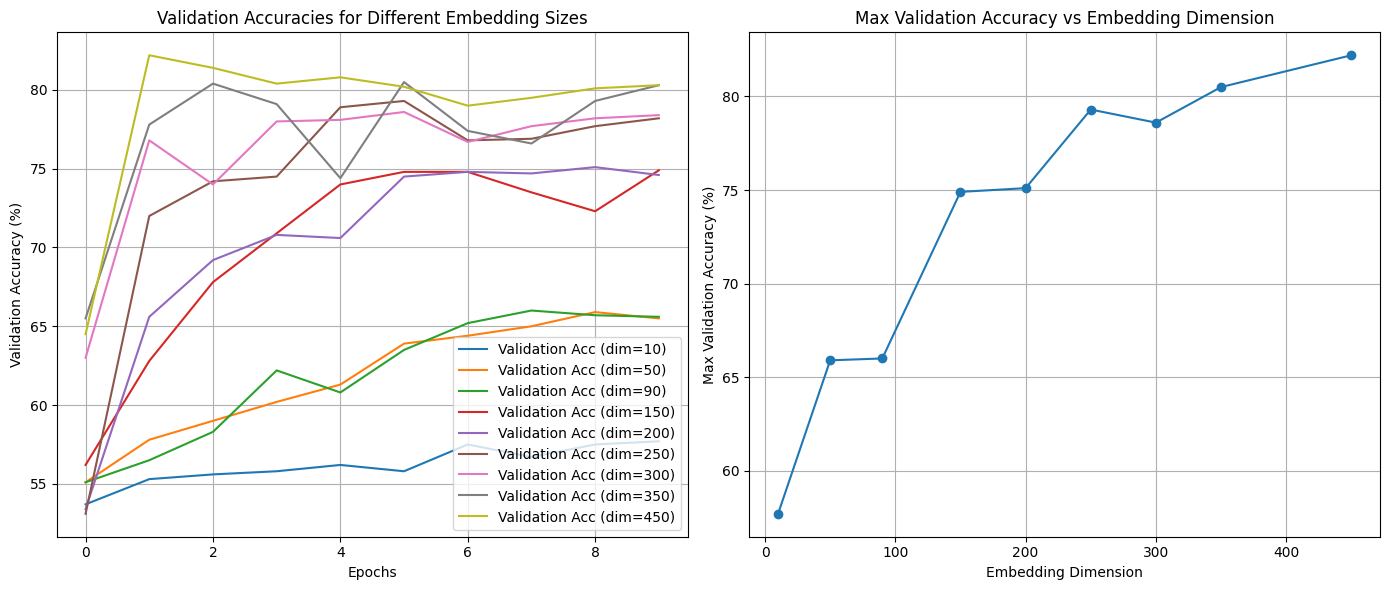

In [ ]:
def plot_side_by_side(valid_accs_dic):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 14 is width, 6 is height

    # Plot validation accuracies over epochs in the first subplot (axes[0])
    for emb_dim, accs in valid_accs_dic.items():
        axes[0].plot(accs, label=f"Validation Acc (dim={emb_dim})")

    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Validation Accuracy (%)")
    axes[0].set_title("Validation Accuracies for Different Embedding Sizes")
    axes[0].legend()
    axes[0].grid(True)

    # Extract the maximum validation accuracy for each embedding size for the second plot
    embedding_sizes = []
    max_accuracies = []

    for emb_dim, accs in valid_accs_dic.items():
        embedding_sizes.append(
            int(emb_dim)
        )  # Convert the embedding dimension to an integer
        max_accuracies.append(
            max(accs)
        )  # Get the maximum accuracy for the current embedding dimension

    # Plot maximum validation accuracy as a function of embedding dimension in the second subplot (axes[1])
    axes[1].plot(embedding_sizes, max_accuracies, marker="o", linestyle="-")
    axes[1].set_xlabel("Embedding Dimension")
    axes[1].set_ylabel("Max Validation Accuracy (%)")
    axes[1].set_title("Max Validation Accuracy vs Embedding Dimension")
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()


plot_side_by_side(valid_accs_dic)